In [1]:
# @title 1. Setup & Dependencies
import sys
import os
import subprocess
import importlib.util

# Install Dependencies
print("Installing dependencies...")
try:
    import moderngl
except ImportError:
    subprocess.check_call(['apt-get', 'install', '-y', 'libgl1-mesa-glx'])
    subprocess.check_call([sys.executable, "-m", "pip", "install", "moderngl"])
    import moderngl

import random
import json
from tqdm import tqdm
import numpy as np
from PIL import Image

# Mount Drive
from google.colab import drive
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# Define Paths
PROJECT_ROOT = '/content/drive/MyDrive/projects/EarthShader'
LIB_DIR = os.path.join(PROJECT_ROOT, 'lib')
RENDERER_PATH = os.path.join(LIB_DIR, 'gl_renderer.py')

if not os.path.exists(RENDERER_PATH):
    raise FileNotFoundError(f"CRITICAL: Renderer file not found at {RENDERER_PATH}")

# Load the library
try:
    spec = importlib.util.spec_from_file_location("gl_renderer", RENDERER_PATH)
    gl_renderer_module = importlib.util.module_from_spec(spec)
    sys.modules["gl_renderer"] = gl_renderer_module
    spec.loader.exec_module(gl_renderer_module)

    # Extract the class we need
    ShaderRenderer = gl_renderer_module.ShaderRenderer
    print("Renderer loaded successfully (Direct File Injection).")

except Exception as e:
    print("\nCRITICAL IMPORT ERROR")
    print(f"Failed to load module from file: {RENDERER_PATH}")
    print(f"Error details: {e}")

# CONFIG
DATASET_ROOT = os.path.join(PROJECT_ROOT, 'dataset/stage1')
IMAGES_DIR = os.path.join(DATASET_ROOT, 'images')
JSONL_PATH = os.path.join(DATASET_ROOT, 'dataset.jsonl')
NUM_SAMPLES = 8000
IMG_SIZE = 512

os.makedirs(IMAGES_DIR, exist_ok=True)

Installing dependencies...
Mounted at /content/drive
Renderer loaded successfully (Direct File Injection).


In [2]:
# @title 2. Shader Templates
# Canonical Templates (Enforcing strict coding style)
# NOTE: We use '{{' to escape the curly brace so Python doesn't treat it as a variable
TEMPLATE_HEADER = """/* ANALYSIS
{analysis}
*/

void mainImage( out vec4 fragColor, in vec2 fragCoord ) {{
    // 1. Setup normalized UV (0,0 is center)
    vec2 uv = (fragCoord - 0.5 * iResolution.xy) / iResolution.y;

    // 2. Define Base Color
    vec3 col = vec3(0.0); // Black background

    // 3. Shape Logic
"""

TEMPLATE_FOOTER = """
    fragColor = vec4(col, 1.0);
}"""

In [3]:
# @title 3. Generator Functions

def random_color():
    # Return a concise vec3 string, e.g., "vec3(1.0, 0.5, 0.2)"
    r = round(random.random(), 2)
    g = round(random.random(), 2)
    b = round(random.random(), 2)
    return f"vec3({r}, {g}, {b})"

def generate_sample(index):
    shape_type = random.choice(['circle', 'square', 'ring'])

    # 1. Randomize Parameters
    pos_x = round(random.uniform(-0.3, 0.3), 2)
    pos_y = round(random.uniform(-0.3, 0.3), 2)
    size = round(random.uniform(0.1, 0.4), 2)
    blur = round(random.uniform(0.001, 0.05), 3) # "smoothstep" width
    color_vec = random_color()

    analysis_lines = [
        f"// Shape: {shape_type.capitalize()}",
        f"// Position: Offset by ({pos_x}, {pos_y})",
        f"// Color: Custom RGB {color_vec}"
    ]

    code_lines = []

    # 2. Build Code Block
    # NOTE: We force the use of length(), max(abs()), smoothstep(), and mix()

    if shape_type == 'circle':
        analysis_lines.append("// Edge: Smoothstep radial distance")
        code_lines.append(f"    // Distance Field for Circle")
        code_lines.append(f"    float d = length(uv - vec2({pos_x}, {pos_y}));")
        code_lines.append(f"    float mask = smoothstep({size}, {size} - {blur}, d);")

    elif shape_type == 'square':
        analysis_lines.append("// Edge: Smoothstep box distance")
        code_lines.append(f"    // Distance Field for Box")
        code_lines.append(f"    vec2 p = abs(uv - vec2({pos_x}, {pos_y}));")
        code_lines.append(f"    float d = max(p.x, p.y);")
        code_lines.append(f"    float mask = smoothstep({size}, {size} - {blur}, d);")

    elif shape_type == 'ring':
        thickness = round(random.uniform(0.02, 0.1), 2)
        analysis_lines.append("// Edge: Annular distance")
        code_lines.append(f"    // Distance Field for Ring")
        code_lines.append(f"    float d = abs(length(uv - vec2({pos_x}, {pos_y})) - {size});")
        code_lines.append(f"    float mask = smoothstep({thickness}, {thickness} - {blur}, d);")

    # 3. Composition (Always use mix)
    code_lines.append(f"    // Composite")
    code_lines.append(f"    col = mix(col, {color_vec}, mask);")

    # Assemble
    analysis_text = "\n".join(analysis_lines)
    glsl_body = "\n".join(code_lines)
    full_code = TEMPLATE_HEADER.format(analysis=analysis_text) + glsl_body + TEMPLATE_FOOTER

    return full_code, analysis_text


In [4]:
# @title 4. Execution Loop (Resume Capable)

# Initialize Renderer
if 'renderer' not in locals():
    try:
        print("Initializing Headless Renderer...")
        renderer = ShaderRenderer(width=IMG_SIZE, height=IMG_SIZE)
    except NameError:
        raise RuntimeError("ShaderRenderer class is not defined. Please rerun Cell 1.")
    except Exception as e:
        raise RuntimeError(f"Failed to initialize renderer context: {e}")

existing_count = 0
dataset_entries = [] # Buffer

# Check if file exists to resume
if os.path.exists(JSONL_PATH):
    with open(JSONL_PATH, 'r') as f:
        existing_count = sum(1 for line in f)
    print(f"Found existing dataset with {existing_count} samples.")
    print("Resuming generation...")
else:
    print("Starting fresh generation...")
    # Create empty file
    with open(JSONL_PATH, 'w') as f:
        pass

if existing_count >= NUM_SAMPLES:
    print(f"Dataset already complete ({existing_count} samples). Skipping generation.")
else:
    print(f"Generating samples {existing_count} to {NUM_SAMPLES}...")
    print(f"Images: {IMAGES_DIR}")

    # Execution Loop (starts where we left off)
    for i in tqdm(range(existing_count, NUM_SAMPLES)):
        # 1. Generate Source
        code, analysis = generate_sample(i)

        # 2. Define Paths
        filename = f"stage1_{i:05d}.png"
        filepath = os.path.join(IMAGES_DIR, filename)

        # 3. Render
        success = renderer.render(code, filepath)

        if success:
            entry = {
                "image_path": filepath,
                "analysis": analysis,
                "code": code
            }
            dataset_entries.append(entry)

            # 4. Incremental Save (Every 20 samples)
            if len(dataset_entries) >= 20:
                with open(JSONL_PATH, 'a') as f:
                    for e in dataset_entries:
                        f.write(json.dumps(e) + '\n')
                dataset_entries = [] # Clear buffer

        else:
            print(f"Warning: Failed to render sample {i}")

    # Flush remaining entries
    if dataset_entries:
        with open(JSONL_PATH, 'a') as f:
            for e in dataset_entries:
                f.write(json.dumps(e) + '\n')

    print(f"Generation Complete. Registry saved to {JSONL_PATH}")

Initializing Headless Renderer...
Found existing dataset with 6100 samples.
Resuming generation...
Generating samples 6100 to 8000...
Images: /content/drive/MyDrive/projects/EarthShader/dataset/stage1/images


100%|██████████| 1900/1900 [02:06<00:00, 15.06it/s]

Generation Complete. Registry saved to /content/drive/MyDrive/projects/EarthShader/dataset/stage1/dataset.jsonl


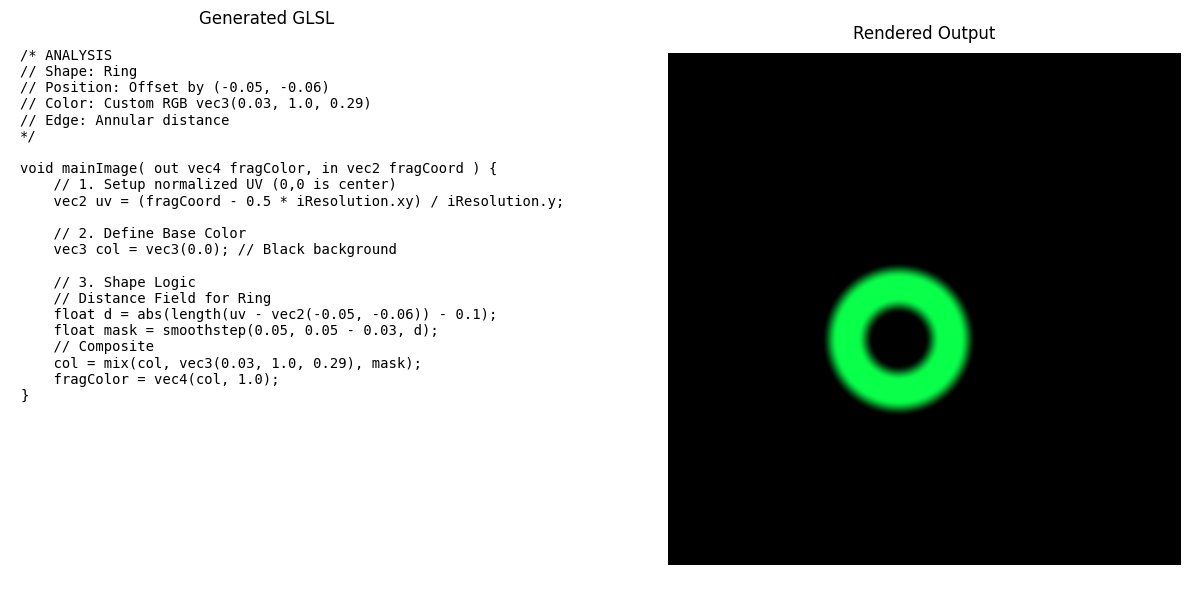

In [14]:
# @title 5. Inspector (Random Sample)
import matplotlib.pyplot as plt
import random

def inspect_random_sample():
    if not os.path.exists(JSONL_PATH):
        print(f"Waiting for data... {JSONL_PATH} not found yet.")
        return

    # Load lines to pick a random one
    with open(JSONL_PATH, 'r') as f:
        lines = f.readlines()

    if not lines:
        print("Dataset is empty.")
        return

    # Pick random entry
    line = random.choice(lines)
    entry = json.loads(line)

    img_path = entry['image_path']
    code = entry['code']

    # Truncate code if too long for the plot
    if len(code) > 800:
        display_code = code[:800] + "\n... [Truncated]"
    else:
        display_code = code

    # Visualization
    if os.path.exists(img_path):
        # Compact layout (12x6 inches)
        plt.figure(figsize=(12, 6))

        # Left: Code
        ax_text = plt.subplot(1, 2, 1)
        ax_text.set_facecolor('#f5f5f5')
        plt.text(0.02, 0.98, display_code,
                fontsize=10,
                family='monospace',
                verticalalignment='top',
                transform=ax_text.transAxes)
        plt.axis('off')
        plt.title("Generated GLSL", fontsize=12, pad=10)

        # Right: Image
        img = Image.open(img_path)
        plt.subplot(1, 2, 2)
        plt.imshow(img)
        plt.axis('off')
        plt.title("Rendered Output", fontsize=12, pad=10)

        plt.tight_layout()
        plt.show()
    else:
        print(f"Image missing at path: {img_path}")

inspect_random_sample()